In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored
import tqdm

In [2]:
mount_path = '/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge'
competition_path = 'data'

In [3]:
def load_data(file_path):
    """
    Reads all data files (metadata and signal matrix data) as python dictionary,
    the pkl and csv files must have the same file name.

    Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

    Returns:
    Python dictionary
    """
    pkl = load_pkl_data(file_path)
    meta = load_csv_metadata(file_path)
    data_dictionary = {**meta, **pkl}

    for key in data_dictionary.keys():
        data_dictionary[key] = np.array(data_dictionary[key])

    return data_dictionary
  


def load_pkl_data(file_path):
    """
    Reads pickle file as a python dictionary (only Signal data).

    Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

    Returns:
    Python dictionary
    """
    path = os.path.join(mount_path, competition_path, file_path + '.pkl')
    with open(path, 'rb') as data:
        output = pickle.load(data)
    return output


def load_csv_metadata(file_path):
    """
    Reads csv as pandas DataFrame (only Metadata).

    Arguments:
    file_path -- {str} -- path to csv metadata file

    Returns:
    Pandas DataFarme
    """
    path = os.path.join(mount_path, competition_path, file_path + '.csv')
    with open(path, 'rb') as data:
        output = pd.read_csv(data)
    return output

In [4]:
def hann(iq, window=None):
    """
    Hann smoothing of 'iq_sweep_burst'.

    Arguments:
    iq -- {ndarray} -- 'iq_sweep_burst' array
    window -- Range of Hann window indices (Default=None)
      If None the whole column is taken

    Returns:
      Regularized iq shaped as (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def calculate_spectrogram(iq_burst, axis=0, flip=True):
    """
    Calculates spectrogram of 'iq_sweep_burst'.

    Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform DFT in (Default = 0)

    Returns:
    Transformed iq_burst array
    """
    iq = np.log(np.abs(np.fft.fft(hann(iq_burst), axis=axis)))
    iq = np.maximum(np.median(iq) - 1, iq)
    if flip:
        iq = np.flip(iq, axis=0)
    return iq

In [5]:
def plot_spectrogram(iq_burst, doppler_burst, color_map_name='parula',
                    color_map_path=None, save_path=None, flip=True, return_spec=False):
    """
    Plots spectrogram of 'iq_sweep_burst'.

    Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving

    Returns:
    Spectrogram data if return_spec is True
    """
    if color_map_path is not None:
        cm_data = np.load(color_map_path)
        color_map = LinearSegmentedColormap.from_list(color_map_name, cm_data)
    elif color_map_name == 'parula':
        print("Error: when 'parula' color map is used, color_map_path should be provided.")
        print("Switching color map to 'viridis'.")
        color_map = None
    else:
        color_map = plt.get_cmap(color_map_name)

    iq = calculate_spectrogram(iq_burst, flip=flip)
  
    if return_spec:
        return iq

    if doppler_burst is not None:
        pixel_shift = 0.5
        if flip:
            plt.plot(pixel_shift + np.arange(len(doppler_burst)),
                    pixel_shift + (len(iq) - doppler_burst), '.w')
        else:
            plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + doppler_burst, '.w')

    plt.imshow(iq, cmap=color_map)
    plt.show()
    if save_path is not None:
        plt.imsave(save_path, iq, cmap=color_map)

    plt.clf()


def get_track_id(data, segment_id):
    """
    Get track id from segment id.

    Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- segment id of a track

    Returns:
    Track id
    """
    segment_index = np.where(data['segment_id'] == segment_id)
    return data['track_id'][segment_index][0]


def has_single_snr_type(data, id, is_segment):
    """
    Check if a track has a single SNR type or both High and Low SNR.

    Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    id -- {int} -- segment or track id, based on is_segment
    is_segment -- {bool} -- If true then id is segment, otherwise id is track

    Returns:
    True if track has a High or Low SNR but not both
    """
    if is_segment:
        id = get_track_id(data, id)
    return np.all(data['snr_type'][np.where(data['track_id'] == id)] == data['snr_type']\
                [np.where(data['track_id'] == id)][0], axis = 0)

In [6]:
def spectrogram(data, segment_id=None, plot_track=False, track_id=None, snr_plot='both',
                color_map_name='parula', color_map_path=None, save_path=None, flip=True,
                return_spec=False):
    """
    Plots spectrogram of a track or of a single segment I/Q matrix ('iq_sweep_burst').
    If segment_id is passed than plots spectrogram for the specific segment,
    unless plot_track=='True' and than plots the entire track of the segment.
    If track_id is passed than plots spectrogram for the entire track.
    In case that the Track has two SNR Types asks the user to choose HighSNR or LowSNR or ignore.
    If color map is 'parula' must pass color_map_path.        

    Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- the segment_id number of the wanted segment
    track_id -- {int} -- the segment_id number of the wanted segment
    snr_plot -- {str} -- If track has both high and low SNR signals which SNR to plot (Default = 'both')
      The valid values are: 'HighSNR', 'LowSNR' or 'both'
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving

    Returns:
    Spectrogram data if return_spec is True
    """
    if (segment_id == None) and (track_id == None):
        raise ValueError("You must pass segment id or track id")
    elif (segment_id != None) and (track_id != None):
        raise ValueError("You must pass segment id or track id, you can't pass both.",
        "\nIf you want to plot the entire track of a segment by passig only the segment_id than set 'plot_track'=True")
    elif (segment_id != None) and (track_id == None):
        segment_index = np.where(data['segment_id'] == segment_id)
        if not plot_track:
            iq_matrix = data['iq_sweep_burst'][segment_index]
            iq_matrix = iq_matrix.reshape(iq_matrix.shape[1], -1)
            doppler_vector = data['doppler_burst'][segment_index]
            doppler_vector = doppler_vector.reshape(doppler_vector.shape[1])
            plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, color_map_name=color_map_name,
                          color_map_path=color_map_path, save_path=save_path, flip=flip, return_spec=return_spec)
        else:
            '''plot_track=True than plots all track by segment_id'''
            track_id = data['track_id'][segment_index]
            spectrogram(data, segment_id=None, plot_track=False, track_id=track_id,
                        snr_plot=snr_plot, color_map_name=color_map_name, 
                        color_map_path=color_map_path, save_path=save_path, flip=flip, 
                        return_spec=return_spec)
    else:
        ''' track_id is passed, plotting the entire track '''
        track_indices = np.where(data['track_id'] == track_id)
        iq_list = []
        dopller_list = []

        if (snr_plot != 'both') and (not has_single_snr_type(data, track_id, False)):
            track_indices = np.where((data['track_id'] == track_id) & (data['snr_type'] == snr_plot))
    
        for i in track_indices:
            iq_list.append(data['iq_sweep_burst'][i])
            dopller_list.append(data['doppler_burst'][i])
      
        iq_matrix = np.concatenate(np.concatenate(iq_list, axis=1),axis=1)
        doppler_vector = np.concatenate(np.concatenate(dopller_list, axis=0),axis=0)

        plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, 
                         color_map_name=color_map_name, color_map_path=color_map_path, 
                         save_path=save_path, flip=flip, return_spec=return_spec)

# Observing differences

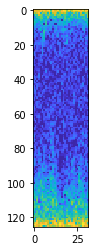

<Figure size 432x288 with 0 Axes>

In [7]:
train_path = 'MAFAT RADAR Challenge - Training Set V1'
data_train = load_data(train_path)

for idx, iq_matrix in enumerate(data_train["iq_sweep_burst"]):
    segment_id = data_train["segment_id"][idx]
    save_path = os.path.join("/home/agarcia/repos/mafat-radar-challenge/spectrograms/test", "segment_" + str(segment_id) + ".jpg")
    plot_spectrogram(iq_burst=iq_matrix, doppler_burst=None, 
                     color_map_name='parula', color_map_path='/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/cmap.npy', 
                     save_path=None, flip=True, return_spec=False)
    break

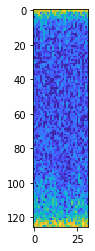

<Figure size 432x288 with 0 Axes>

In [8]:
synth_path = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
data_synth = load_data(synth_path)

for idx, iq_matrix in enumerate(data_synth["iq_sweep_burst"]):
    segment_id = data_synth["segment_id"][idx]
    save_path = os.path.join("/home/agarcia/repos/mafat-radar-challenge/spectrograms/test", "segment_" + str(segment_id) + ".jpg")
    plot_spectrogram(iq_burst=iq_matrix, doppler_burst=None, 
                     color_map_name='parula', color_map_path='/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/cmap.npy', 
                     save_path=None, flip=True, return_spec=False)
    break

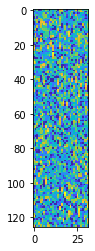

<Figure size 432x288 with 0 Axes>

In [9]:
a = data_synth["iq_sweep_burst"][0] - data_train["iq_sweep_burst"][0]
plot_spectrogram(iq_burst=a, doppler_burst=None, 
                     color_map_name='parula', color_map_path='/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/cmap.npy', 
                     save_path=None, flip=True, return_spec=False)

# Seeing CSV differences

In [98]:
train_df = pd.read_csv("/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Training Set V1.csv")
aux_df = pd.read_csv("/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Auxiliary Synthetic Set V2.csv")
aux_df_bis = pd.read_csv("/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Auxiliary Experiment Set V2.csv")
bkgrd_df = pd.read_csv("/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Auxiliary Background(empty) Set V1.csv")

In [25]:
train_df.shape

(6656, 8)

In [36]:
train_df.segment_id.unique().shape

(6656,)

In [39]:
aux_df.segment_id = aux_df.segment_id - 2000000

In [40]:
aux_df[aux_df.segment_id.isin(train_df.segment_id)].shape

(2465, 8)

In [41]:
aux_df[aux_df.segment_id.isin(aux_df_bis.segment_id)].shape

(48418, 8)

In [44]:
aux_df.shape

(50883, 8)

In [100]:
bkgrd_df.segment_id = bkgrd_df.segment_id - 1000000

In [ ]:
aux_idx = list(bkgrd_df[bkgrd_df.segment_id.isin(train_df.segment_id)].index)

In [108]:
bkgrd_df.shape

(31128, 8)

# Measuring differences (statistically ;)

In [52]:
train_idx = list(train_df[train_df.segment_id.isin(aux_df.segment_id)].index)

In [53]:
aux_idx = list(aux_df[aux_df.segment_id.isin(train_df.segment_id)].index)

In [54]:
for key, value in data_train.items():
    data_train[key] = data_train[key][train_idx]
    data_synth[key] = data_synth[key][aux_idx]

In [115]:
a = data_synth["iq_sweep_burst"][0]
b = data_train["iq_sweep_burst"][0]
c = np.abs(a) - np.abs(b)
print(np.mean(c))
print(np.std(c))

89.91837284648437
667.0165432239207


In [126]:
a = data_synth["iq_sweep_burst"][1]
b = data_train["iq_sweep_burst"][1]
c = np.log(np.abs(a)) - np.log(np.abs(b))
print(np.mean(c))
print(np.std(c))

0.378231500790403
0.7434843202891861


In [17]:
data_train["iq_sweep_burst"].shape

(6656, 128, 32)

In [71]:
train_df[train_df.segment_id.isin(aux_df.segment_id)].head(20)

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type
0,0,11,C,1,1,HighSNR,27,animal
1,1,16,C,1,1,HighSNR,27,animal
2,2,16,C,1,1,HighSNR,27,animal
3,3,29,C,1,1,HighSNR,27,animal
4,4,29,C,1,1,HighSNR,27,animal
5,5,29,C,1,1,HighSNR,27,animal
6,6,29,C,1,1,HighSNR,27,animal
7,7,29,C,1,1,HighSNR,27,animal
8,8,29,C,1,1,HighSNR,27,animal
9,9,29,C,1,1,HighSNR,27,animal


In [88]:
a = data_synth["iq_sweep_burst"][20]
b = data_train["iq_sweep_burst"][20]
c = a - b
print(np.mean(np.abs(c[:,0])))
print(np.std(np.abs(c[:,0])))

1722.954830632987
942.0505843450392


In [137]:
a = data_synth["iq_sweep_burst"][20]
b = data_train["iq_sweep_burst"][20]
c = a - b
print(np.mean(calculate_spectrogram(a)))
print(np.mean(calculate_spectrogram(b)))
print(np.std(calculate_spectrogram(a) - calculate_spectrogram(b)))

9.347837225136518
7.780975026340473
0.8876978124401401


In [138]:
a = data_synth["iq_sweep_burst"][0]
b = data_train["iq_sweep_burst"][0]
c = a - b
print(np.mean(calculate_spectrogram(a)))
print(np.mean(calculate_spectrogram(b)))
print(np.std(calculate_spectrogram(a)/calculate_spectrogram(b)))

9.030235100833394
8.285539823427934
0.1023795155776346


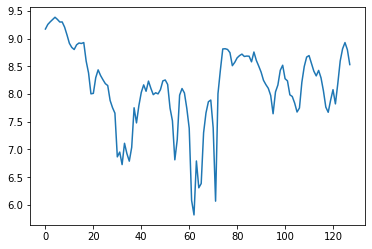

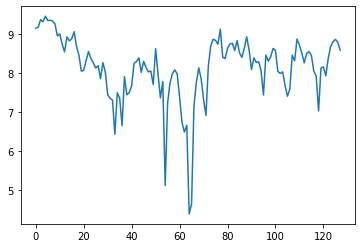

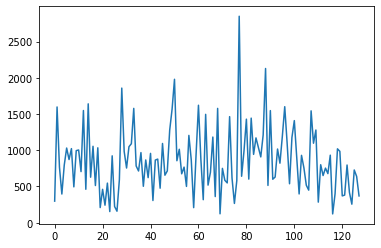

In [110]:
plt.figure()
plt.plot(np.log(np.abs(data_train["iq_sweep_burst"][0][:, 0])))
plt.figure()
plt.plot(np.log(np.abs(data_synth["iq_sweep_burst"][0][:, 0])))
plt.figure()
plt.plot(np.abs(data_train["iq_sweep_burst"][0][:, 0] - data_synth["iq_sweep_burst"][0][:, 0]))

In [ ]:
plt.plot(np.abs(data_synth["iq_sweep_burst"][0][:, 0]))